## Install Lib

In [4]:
!pip install osmnx


## Import Modules

In [5]:
import pandas as pd
import osmnx as ox
import networkx as nx
import random
import numpy as np
import heapq
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# do not show any warnings
import warnings
warnings.filterwarnings('ignore')

## Explore Data

In [6]:
# —————— 1. Load & filter your station data ——————

cs_df = pd.read_csv(
    "los_angeles.csv"
)

In [7]:
cs_df.head()

,Station Name,Street Address,City,State,ZIP,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude,ID
0,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,90015,12,0,34.040539,-118.271387,1523
1,Music Center Parking - Level 2,135 N Grand Ave,Los Angeles,CA,90012,8,1,34.057657,-118.247890,21374
2,LADWP - Lincoln Heights District,3101 Artesian St,Los Angeles,CA,90031,4,1,34.081998,-118.217130,33179
3,Nissan of Downtown Los Angeles,635 W Washington Blvd,Los Angeles,CA,90015,4,3,34.035168,-118.273229,48129
4,Los Angeles Zoo,5333 Zoo Dr,Los Angeles,CA,90027,4,1,34.148873,-118.283976,70010


In [8]:
# —————— 2. Load road network ——————
random.seed(10)
np.random.seed(10)

print("Loading road network...")
city = "Los Angeles, California, USA"
G = ox.graph_from_place(city, network_type='drive')
G_undirected = G.to_undirected()

# precompute node positions for plotting
node_gdf = ox.graph_to_gdfs(G, nodes=True, edges=False)
node_positions = {node: (data['x'], data['y']) for node, data in node_gdf.iterrows()}
print("Road network ready")

Loading road network...
Road network ready


In [9]:
# —————— 3. Snap stations to nearest graph nodes ——————
station_nodes = ox.nearest_nodes(
    G,
    X=cs_df['Longitude'].values,
    Y=cs_df['Latitude'].values
).tolist()

# Build a capacity dict: sum of level-2 + fast-charger ports (at least 1)
charging_capacity = {}
for node, (_, row) in zip(station_nodes, cs_df.iterrows()):
    cap = row['EV Level2 EVSE Num'] + row['EV DC Fast Count']
    charging_capacity[node] = max(1, int(cap))

# Track current usage (initially zero)
station_current_usage = {node: 0 for node in station_nodes}


In [10]:
# ─── 4. Pick start & goal ───
nodes = list(G.nodes)
start_node, goal_node = random.sample(nodes, 2)
while not nx.has_path(G_undirected, start_node, goal_node):
    start_node, goal_node = random.sample(nodes, 2)
print(f"Start: {start_node}, Goal: {goal_node}")

Start: 370004248, Goal: 122500554


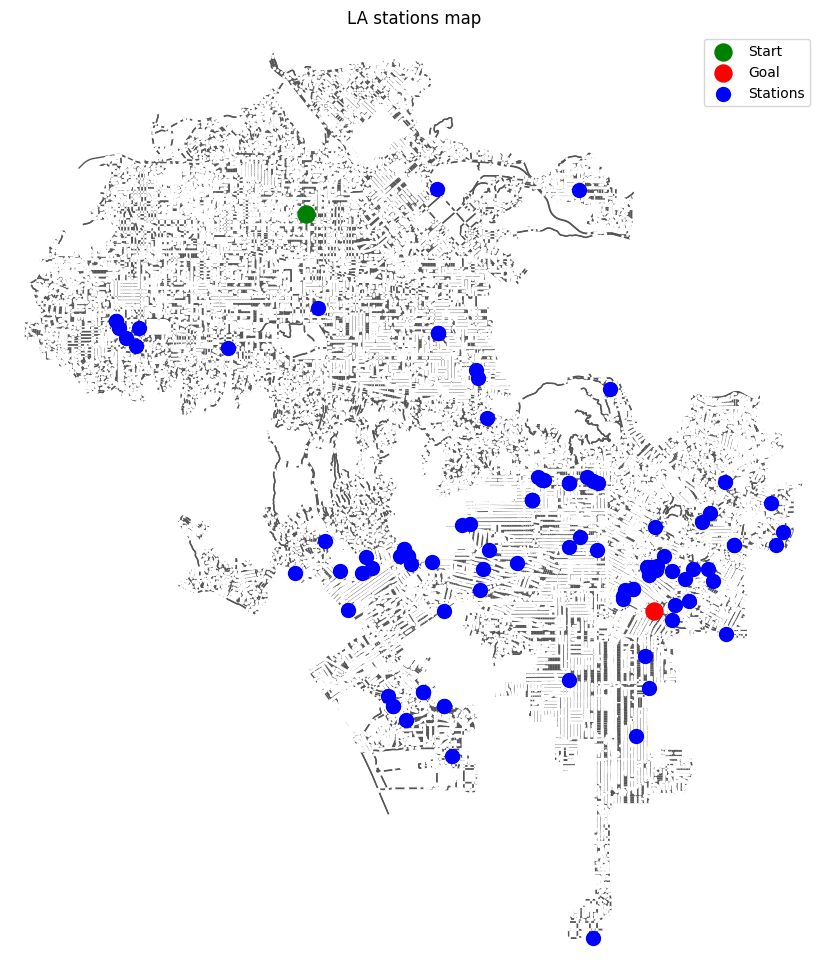

In [11]:
# —————— 8. Visualization functions ——————
def visualize_policy():
    fig, ax = plt.subplots(figsize=(12,12))
    ox.plot_graph(G, ax=ax, bgcolor='k', node_size=5, edge_color='#555555', show=False)


    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=[start_node],
                           node_color='green', node_size=150, label='Start')
    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=[goal_node],
                           node_color='red',   node_size=150, label='Goal')
    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=station_nodes,
                           node_color='blue',  node_size=100, label='Stations')

    plt.title("LA stations map")
    plt.legend()
    plt.show()

# show the policy
visualize_policy()

In [12]:
# ____ Calculate the shortest path ________
shortest_path = nx.shortest_path(G, source=start_node, target=goal_node, weight='length')

# Calculate the total length of that path
path_length = nx.shortest_path_length(G, source=start_node, target=goal_node, weight='length')

print(f"Shortest path length: {path_length:.2f} meters")
print("Path node sequence:", shortest_path)


Shortest path length: 36477.44 meters
Path node sequence: [370004248, 370003510, 369998324, 370006125, 369998347, 370006956, 369998407, 122684285, 122650817, 122650958, 122684283, 122684281, 2594722281, 370347002, 122684276, 122684273, 122684270, 122684267, 122684263, 122684260, 122684254, 122684252, 122684249, 122684246, 6392921988, 6392004061, 122746779, 7345484706, 1887613417, 1887613413, 1887613414, 5159823750, 1887613415, 122990638, 122990892, 317105945, 317106031, 12181630978, 317105674, 317105631, 317105037, 317105083, 361108909, 306526013, 4052011406, 4052011391, 306526345, 1377610420, 361449050, 122522127, 361450999, 361452295, 361454859, 362409184, 362409104, 1957285381, 21703085, 29570294, 21703087, 166914602, 122520856, 29570298, 167930172, 6354846118, 167930034, 269389405, 338835931, 35361266, 2351743393, 74671700, 1837462644, 8076753689, 2351743387, 349220787, 1836345664, 2425825962, 2354337201, 1613371895, 21748363, 2425824150, 2354337157, 2354337175, 2354195323, 1613487

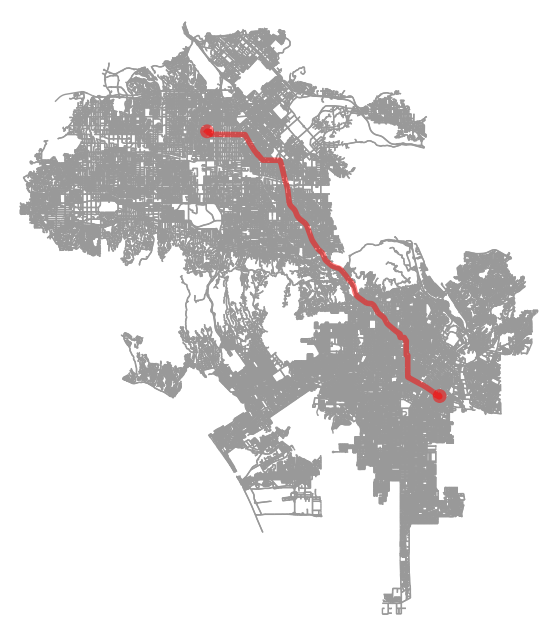

In [13]:
# Plot the shortest path on the map
fig, ax = ox.plot_graph_route(G, shortest_path, route_linewidth=4, node_size=0, bgcolor='white')


In [21]:
# —————— 5. EV & battery settings ——————
battery_max   = 100
battery_start = 10
battery_efficiency =1

# Compute battery cost on each edge
for u, v, data in G.edges(data=True):
    data['battery_cost'] = data.get('length', 0) * battery_efficiency

In [22]:
def find_nearest_station(G, G_undirected, station_nodes, current_node, battery, goal_node):
    """
    Among all charging stations that:
      - are reachable from current_node with your current battery
    pick the one with the smallest remaining distance to goal_node.
    Returns the directed shortest_path to that station, or None.
    """
    best = None   # tuple: (dist_station_to_goal_m, path_to_station)

    for station in station_nodes:
        # 1) can we reach this station?
        try:
            path_to = nx.shortest_path(G, current_node, station, weight='length')
        except nx.NetworkXNoPath:
            continue

        # battery cost to get there
        total_to_m = sum(
            G.get_edge_data(path_to[i], path_to[i+1]).get(0, {}).get('length', 1000)
            for i in range(len(path_to) - 1)
        )
        cost_to = (total_to_m / 1000.0) * battery_efficiency
        if cost_to > battery:
            continue

        # 2) how far from station → goal?
        try:
            path_from = nx.shortest_path(G, station, goal_node, weight='length')
        except nx.NetworkXNoPath:
            continue
        total_from_m = sum(
            G.get_edge_data(path_from[i], path_from[i+1]).get(0, {}).get('length', 1000)
            for i in range(len(path_from) - 1)
        )

        # 3) pick the station with smallest remaining distance to goal
        if best is None or total_from_m < best[0]:
            best = (total_from_m, path_to)

    return best[1] if best else None


In [24]:
# --- Main simulation loop ---
current_node = start_node
path = [current_node]
charging_stops = []
battery_levels = [battery]

while current_node != goal_node and iterations < max_iterations:
    iterations += 1

    # === Charging logic ===
    if current_node in station_nodes and battery < battery_max:
        charging_stops.append(current_node)
        battery = battery_max
        battery_levels[-1] = battery
        print(f"[CHARGING] At node {current_node} → Battery recharged to {battery:.2f}%")

    # === Proactive check: can we go straight to goal? ===
    try:
        direct_path = nx.shortest_path(G, current_node, goal_node, weight='length')
        total_m = sum(
            G.get_edge_data(direct_path[i], direct_path[i+1]).get(0, {}).get('length', 1000)
            for i in range(len(direct_path) - 1)
        )
        battery_needed = (total_m / 1000.0) * battery_efficiency
    except nx.NetworkXNoPath:
        battery_needed = float('inf')

    if battery >= battery_needed:
        print(f"[SUCCESS] Direct to goal from {current_node}. Battery: {battery:.2f}% → {battery - battery_needed:.2f}%")
        path.extend(direct_path[1:])
        battery -= battery_needed
        battery_levels.append(battery)
        current_node = goal_node
        break

    # === Need to recharge: find nearest station ===
    print(f"[PRECHECK] Battery too low ({battery:.2f}% < {battery_needed:.2f}%). Looking for station...")
    station_path = find_nearest_station(
        G, G_undirected, station_nodes,
        current_node, battery, goal_node
    )

    if station_path and len(station_path) > 1:
        # drive to station
        for u, v in zip(station_path, station_path[1:]):
            length_km = G.get_edge_data(u, v).get(0, {}).get('length', 1000) / 1000.0
            cost = length_km * battery_efficiency
            if battery < cost:
                print(f"[FAIL] Can't reach {v} from {u}. Battery {battery:.2f}%, needed {cost:.2f}%")
                break
            battery -= cost
            current_node = v
            path.append(v)
            battery_levels.append(battery)
            print(f"[MOVE] {u} → {v} | Cost: {cost:.2f}% → Battery: {battery:.2f}%")
        else:
            # arrived at station; next loop iteration will trigger charge
            continue
    else:
        print("[PRE-FAIL] No reachable station found. Stopping.")
        break

# === Final report ===
print("\n=== SIMULATION RESULT ===")
if iterations >= max_iterations:
    print(f"[LIMIT] Max iterations reached: {max_iterations}")
elif current_node == goal_node:
    print(f"[SUCCESS] Reached goal node {goal_node}")
    print(f"→ Total steps: {len(path)}")
    print(f"→ Charging stops: {len(charging_stops)}")
else:
    print("[FAILURE] Could not reach the goal node.")

[PRECHECK] Battery too low (10.00% < 36.48%). Looking for station...
[MOVE] 370004248 → 370003510 | Cost: 0.01% → Battery: 9.99%
[MOVE] 370003510 → 369998324 | Cost: 0.15% → Battery: 9.84%
[MOVE] 369998324 → 370006125 | Cost: 0.01% → Battery: 9.83%
[MOVE] 370006125 → 369998347 | Cost: 0.14% → Battery: 9.69%
[MOVE] 369998347 → 370006956 | Cost: 0.05% → Battery: 9.64%
[MOVE] 370006956 → 369998407 | Cost: 0.21% → Battery: 9.43%
[MOVE] 369998407 → 122684285 | Cost: 0.23% → Battery: 9.20%
[MOVE] 122684285 → 122737946 | Cost: 0.21% → Battery: 8.99%
[MOVE] 122737946 → 123236592 | Cost: 0.19% → Battery: 8.79%
[MOVE] 123236592 → 122746824 | Cost: 0.40% → Battery: 8.39%
[MOVE] 122746824 → 1887606941 | Cost: 0.09% → Battery: 8.31%
[MOVE] 1887606941 → 4059333610 | Cost: 0.12% → Battery: 8.19%
[MOVE] 4059333610 → 3835224570 | Cost: 0.06% → Battery: 8.13%
[MOVE] 3835224570 → 272168769 | Cost: 0.34% → Battery: 7.79%
[MOVE] 272168769 → 362824649 | Cost: 0.88% → Battery: 6.92%
[MOVE] 362824649 → 593060

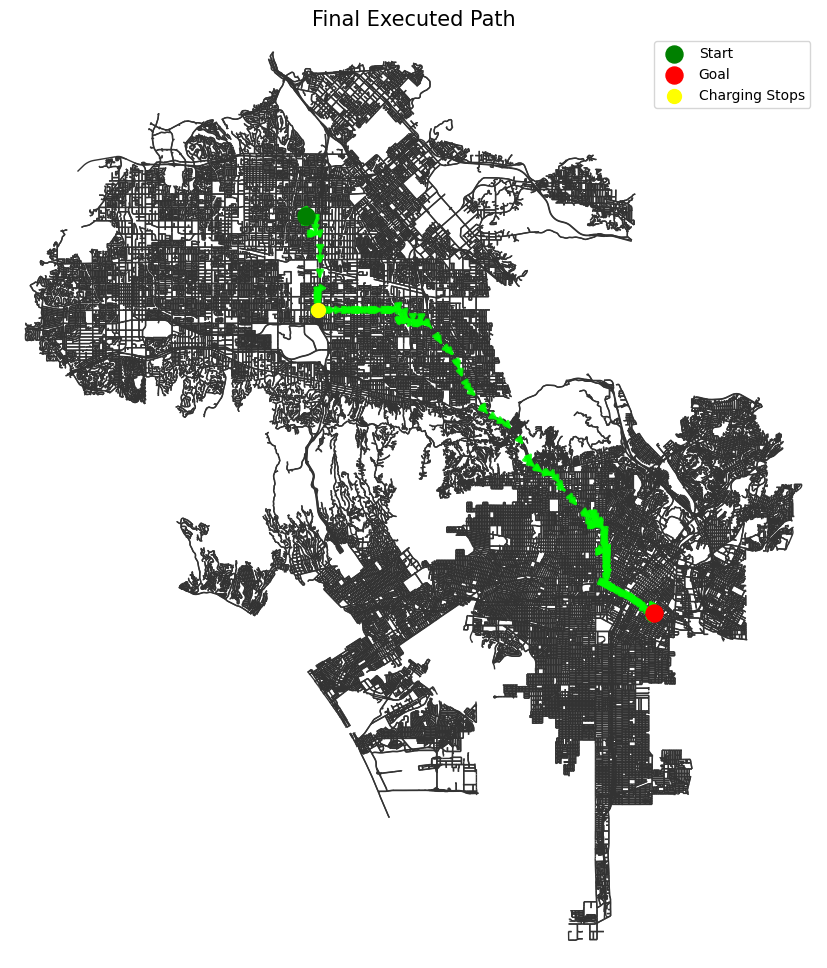

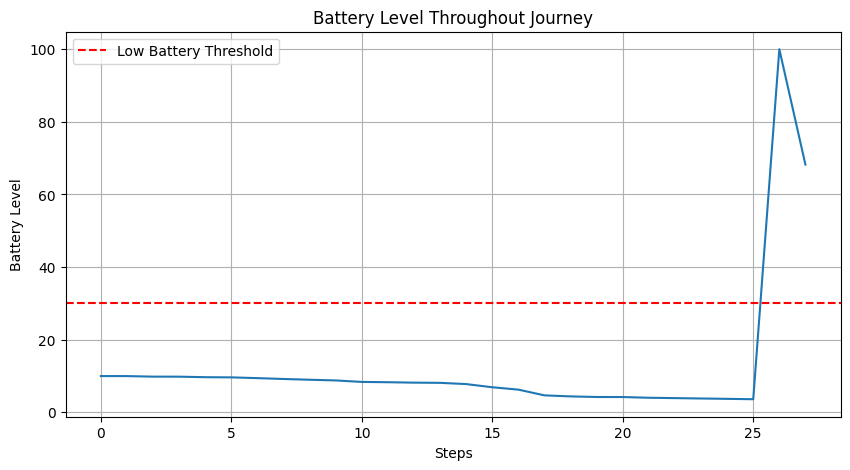

In [25]:
# Plot path
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, ax=ax, bgcolor='k', node_size=0, edge_color='#333333', show=False)
nx.draw_networkx_edges(G, pos=node_positions, edgelist=list(zip(path[:-1], path[1:])),
                       edge_color='lime', width=2, alpha=0.8)
nx.draw_networkx_nodes(G, pos=node_positions, nodelist=[start_node], node_color='green', node_size=150, label='Start')
nx.draw_networkx_nodes(G, pos=node_positions, nodelist=[goal_node], node_color='red', node_size=150, label='Goal')
nx.draw_networkx_nodes(G, pos=node_positions, nodelist=charging_stops, node_color='yellow', node_size=100, label='Charging Stops')
plt.title("Final Executed Path", fontsize=15)
plt.legend()
plt.show()  # Show the figure instead of saving

# Plot battery levels
plt.figure(figsize=(10, 5))
plt.plot(battery_levels)
plt.axhline(y=safety_threshold, color='r', linestyle='--', label='Low Battery Threshold')
plt.xlabel('Steps')
plt.ylabel('Battery Level')
plt.title('Battery Level Throughout Journey')
plt.legend()
plt.grid(True)
plt.show()  # Show the battery level plot
